In [64]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import utils

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, RepeatVector, Reshape, Lambda, concatenate
from tensorflow.keras.layers import Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
# from tensorflow.keras.callbacks.tensorboard_v1 import Tensorboard
from tensorflow.keras import backend as K

tf.__version__


'2.0.0'

In [65]:
os.listdir('./data')

['DJI_fe.csv',
 'DJI_STO_20period_sma10.csv',
 'N225.csv',
 'DJI_modified_features - DJI.csv',
 'N225fillVOL.csv',
 'DJI_modified_sma.csv',
 'downjone5y.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 '.ipynb_checkpoints',
 'DJI_ema.csv',
 'DJI_denoise.csv']

In [66]:
# data stats parameter
val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

# hyperparameter
batch_size = 1024
epochs = 100
lr = 1e-3
decay = 1e-2

In [67]:
# callback setup
log_name = 'seq2seq_1'

tensorboard_callback = TensorBoard(log_dir="logs/" + log_name)
modelcheckpoint_callback = ModelCheckpoint("save_model/" + log_name + "_{epoch:02d}_weight.hdf5", save_best_only=True)

callbacks_list = [
    tensorboard_callback,
    modelcheckpoint_callback
]

In [68]:
df = pd.read_csv('./data/DJI_fe.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0.1', axis=1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma_5,sma_10,sma_25,...,sma_125,sma_200,%K,%D,ema_5,ema_10,ema_25,ema_75,ema_125,ema_200
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1291.039998,1291.758179,1292.255380,1292.495258,1292.544757,1292.572831
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1289.616672,1290.851241,1291.833430,1292.344594,1292.453095,1292.515092
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1285.651105,1288.463737,1290.747779,1291.959736,1292.219235,1292.367876
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.013989,NaN,NaN,...,NaN,NaN,NaN,NaN,1287.127389,1288.757595,1290.696408,1291.910268,1292.185279,1292.345111


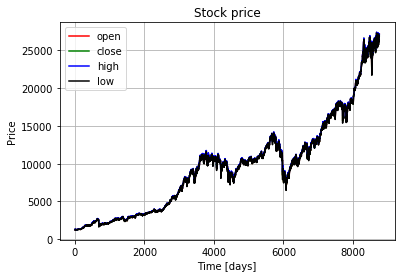

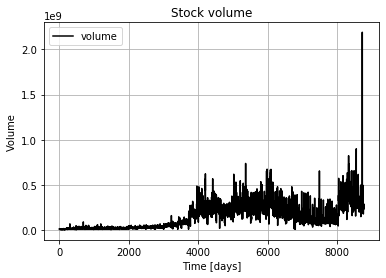

In [69]:
utils.plot_raw(df)

In [70]:
df = df.dropna()
df = df.drop('Date', axis=1)
df = df.drop('Adj Close', axis=1)
df = df.drop('Volume', axis=1)

In [71]:
cols = ['Open', 'Close', 'High', 'Low']
# range_ma = [5, 10, 25, 75, 125, 200]
# for ma in range_ma:
#     cols.append('sma_' + str(ma))
#     cols.append('ema_' + str(ma))

print(cols)
print(len(cols))


df_norm = utils.normalize_data(df,cols)

x_train, y_train, x_val, y_val, x_test, y_test = utils.load_data(df_norm[cols])


['Open', 'Close', 'High', 'Low']
4


/Users/2two2/Documents/MultimodelStockPrediction/utils.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_raw = stock.as_matrix()


In [72]:
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (6835, 19, 4)
y_train.shape =  (6835, 4)
x_val.shape =  (854, 19, 4)
y_val.shape =  (854, 4)
x_test.shape =  (854, 19, 4)
y_test.shape =  (854, 4)


In [74]:
weight_path_model = "saved_model/model_seq2word.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
]

In [75]:
# ! seq2word not real seq2seq
def seq2word_model():
    seq_len = 20 - 1
    
    # Encoder
    encoder_inputs = Input(shape=(19, 4))
    encoder = LSTM(100, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]
    
    # Decoder
    reshaper = Reshape((1, 100), name='reshaper')
    decoder = LSTM(100, return_sequences=True, return_state=True,
                  name='decoder')
    
    # Fully-connected
    fc_output = Dense(4, activation='linear', 
              name='fc')
    
    # Reshape output
    reshaper_output = Reshape((4,), name='reshaper_output')
    
    inputs = reshaper(encoder_outputs)
    outputs, h, c = decoder(inputs, initial_state=states)
        
    inputs = outputs
    states = [h, c]

    outputs = reshaper_output(fc_output(outputs))

    model = Model(inputs=encoder_inputs, outputs=outputs)
    
    model.compile(optimizer=Adam(learning_rate=lr, decay=decay),
                loss='mse',
                metrics=['mse'])   
    
#     model.summary()
    
    return model

def seq2seq_model():
    seq_len = 20 - 1
    
    # Encoder
    encoder_inputs = Input(shape=(19, 4))
    encoder = LSTM(100, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]
    
    # Decoder
    reshaper = Reshape((1, 100), name='reshaper')
    decoder = LSTM(100, return_sequences=True, return_state=True,
                  name='decoder')
    
    # Fully-connected
    fc_output = Dense(4, activation='linear', 
              name='fc')

    inputs = reshaper(encoder_outputs)

    all_outputs = list()
    
    for _ in range(seq_len):
        outputs, h, c = decoder(inputs, initial_state=states)
        
        inputs = outputs
        states = [h, c]
        
        outputs = fc_output(outputs)
        all_outputs.append(outputs)
        
    decoder_outputs = Lambda(lambda x: concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
    
    model.compile(optimizer=Adam(learning_rate=lr, decay=decay),
                loss='mse',
                metrics=['mse'])   
    
#     model.summary()
    
    return model



In [79]:
y_train.shape

(6835, 4)

In [80]:
K.clear_session()

# predict
# model_word = seq2word_model()

# history = model_word.fit(x_train, y_train, epochs=epochs,
#                    validation_data=(x_val, y_val), 
#                    batch_size=batch_size, callbacks=callbacks_list_model)

model_word = seq2word_model()

history = model_word.fit(x_train, y_train, epochs=epochs,
                   validation_data=(x_val, y_val), 
                   batch_size=batch_size, callbacks=callbacks_list_model)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19, 4)]      0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 100), (None, 42000       input_1[0][0]                    
__________________________________________________________________________________________________
reshaper (Reshape)              (None, 1, 100)       0           encoder[0][0]                    
__________________________________________________________________________________________________
decoder (LSTM)                  [(None, 1, 100), (No 80400       reshaper[0][0]                   
                                                                 encoder[0][1]                

Epoch 21/100
6144/6835 [=========================>....] - ETA: 0s - loss: 4.0678e-05 - mse: 4.0678e-05
Epoch 00021: val_loss did not improve from 0.00008
6835/6835 [==============================] - 3s 368us/sample - loss: 4.0245e-05 - mse: 4.0245e-05 - val_loss: 8.4592e-05 - val_mse: 8.4592e-05
Epoch 22/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.9501e-05 - mse: 3.9501e-05
Epoch 00022: val_loss did not improve from 0.00008
6835/6835 [==============================] - 2s 273us/sample - loss: 4.0168e-05 - mse: 4.0168e-05 - val_loss: 8.1285e-05 - val_mse: 8.1285e-05
Epoch 23/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.9452e-05 - mse: 3.9452e-05
Epoch 00023: val_loss did not improve from 0.00008
6835/6835 [==============================] - 2s 259us/sample - loss: 4.0019e-05 - mse: 4.0019e-05 - val_loss: 8.3385e-05 - val_mse: 8.3385e-05
Epoch 24/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.9398e-05 - mse: 3.9398e-05
Epoch 

6144/6835 [=========================>....] - ETA: 0s - loss: 3.8356e-05 - mse: 3.8356e-05
Epoch 00046: val_loss did not improve from 0.00008
6835/6835 [==============================] - 2s 246us/sample - loss: 3.8332e-05 - mse: 3.8332e-05 - val_loss: 7.5869e-05 - val_mse: 7.5869e-05
Epoch 47/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.8088e-05 - mse: 3.8088e-05
Epoch 00047: val_loss did not improve from 0.00008
6835/6835 [==============================] - 2s 244us/sample - loss: 3.8269e-05 - mse: 3.8269e-05 - val_loss: 7.5806e-05 - val_mse: 7.5806e-05
Epoch 48/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.7960e-05 - mse: 3.7960e-05
Epoch 00048: val_loss did not improve from 0.00008
6835/6835 [==============================] - 2s 241us/sample - loss: 3.8234e-05 - mse: 3.8234e-05 - val_loss: 7.5731e-05 - val_mse: 7.5731e-05
Epoch 49/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.8351e-05 - mse: 3.8351e-05
Epoch 00049: val_lo

Epoch 74/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.7573e-05 - mse: 3.7573e-05
Epoch 00074: val_loss did not improve from 0.00008
6835/6835 [==============================] - 3s 465us/sample - loss: 3.7172e-05 - mse: 3.7172e-05 - val_loss: 8.3457e-05 - val_mse: 8.3457e-05
Epoch 75/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.7647e-05 - mse: 3.7647e-05
Epoch 00075: val_loss did not improve from 0.00008
6835/6835 [==============================] - 3s 392us/sample - loss: 3.7141e-05 - mse: 3.7141e-05 - val_loss: 8.3862e-05 - val_mse: 8.3862e-05
Epoch 76/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.6512e-05 - mse: 3.6512e-05
Epoch 00076: val_loss did not improve from 0.00008
6835/6835 [==============================] - 2s 340us/sample - loss: 3.7112e-05 - mse: 3.7112e-05 - val_loss: 8.4832e-05 - val_mse: 8.4832e-05
Epoch 77/100
6144/6835 [=========================>....] - ETA: 0s - loss: 3.6569e-05 - mse: 3.6569e-05
Epoch 

In [81]:
y_train_pred = model_seq.predict(x_train)
y_val_pred = model_seq.predict(x_val)
y_test_pred = model_seq.predict(x_test)

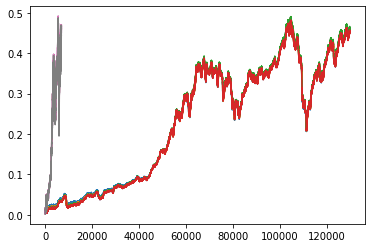

In [82]:
# utils.plot_result(y_train, y_val, y_test, y_train_pred, y_val_pred, y_test_pred, ft=0)
# y_train_pred = y_train_pred.reshape(-1, 4)
# y_train_pred = y_train_pred[:, 0]
# print('shape : ', y_train_pred.shape)
# y_train = y_train.reshape(-1, 4)
# y_train = y_train[:, 0]

plt.plot(y_train_pred_trans, label='pred')
plt.plot(y_train, label='actual')
plt.show()

In [45]:
df = pd.DataFrame({"eiei":[1,2,3], "yeah":[4,5,6]})
mat = df.as_matrix()


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[1, 4],
       [2, 5],
       [3, 6]])

In [46]:
x = np.array([[[1,2,3],[4,5,6]],
[[7,8,9],[10,11,12]]])

In [50]:
x

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

In [51]:
x.shape

(2, 2, 3)

In [52]:
x[:,-1,:]

array([[ 4,  5,  6],
       [10, 11, 12]])